### Bayesian Logistic Regression with Degraded Fashion MNIST

This notebook demonstrates a Bayesian Logistic Regression model applied to the Fashion MNIST dataset. It includes functionalities for degrading images by setting a percentage of pixels to zero in a fixed, deterministic order, and then evaluating the model's performance under varying levels of degradation.

I run this in google colab.

Make sure to select a runtime with a GPU. There is a free one called 'T4'.

In [1]:
# start by installing relevant libraries
!pip install ipython-autotime numpyro blackjax tqdm nutpie tensorflow pymc
%load_ext autotime

time: 168 μs (started: 2025-11-21 10:46:12 +01:00)


In [1]:
# Some general setup. import libraries.
import numpy as np
from tensorflow.keras.datasets import fashion_mnist
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
import os
import tqdm
import polars as pl
import pandas as pd

#  Configuration. Setting constants
N_PIXELS = 28 * 28  # 784
N_CLASSES = 10
DEGRADATION_TRAIN = 0.85

# with only one GPU device, a single chain is what we can do easily. One can of course run multiple runs
# but the pymc library wont do chains in parallell if trying a GPU sampler and with just 1 GPU available
N_CHAINS = 1

# We make 1k posterior samples in the one chain.
# if running on CPU of multiple GPUs one could have fewer samples per chain.
# more chains = more precise computation
# I did a first rough run, and adding more samples did not seems to alter the quality that much
# so 1k should be fine, I think
N_DRAWS = 1000
RANDOM_SEED = 42

# To reduce the runtime, we can pick some subsample
# I tried 0.5k, 1k, 2k and 3k samples for training.
# took a minute or two to train.
# 5k train samples took 7 minutes with blackjax on T4 (see below) so I think you can scale this up significantly
# or even include all data for the final run
N_TRAIN_SAMPLES = 2000 # Reduce training data for faster execution

# you should have all the test data in the final run, which only takes a few minutes
# but I took a subset for when developing this notebook
N_TEST_SAMPLES = 2000



# Data Preparation
We will handle the data as 1-dimensional vectors scaled on interval [0,1]

In [ ]:

print("Loading and preparing Fashion MNIST dataset...")

# Load the data
#(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()
# Extract training set from MNIST dataset.
fashion_train_df = pd.read_csv('data_copy/raw/fashion-mnist-train.csv')
fashion_test_df = pd.read_csv('data_copy/raw/fashion-mnist-test.csv')

np.random.seed(0)

N = len(fashion_train_df)
indices = np.random.permutation(N)  # shuffled indices, reproducible because of seed

# Calculate absolute sizes
n_train = int(0.9 * N)   
n_val = int(0.1 * N)    
#n_comb = N - (n_train + n_val)  # remaining 40%

# Assign splits
idx_train = indices[:n_train]
idx_val = indices[n_train:n_train + n_val]
#idx_comb = indices[n_train + n_val:]

# Get DataFrames
train_df = fashion_train_df.iloc[idx_train]
val_df = fashion_train_df.iloc[idx_val]
#comb_df = fashion_train_df.iloc[idx_comb]

# Extract arrays
X_train_flat = train_df.drop(columns=["label"]).to_numpy() / 255.0
Y_train = train_df["label"].to_numpy()

X_test_flat = fashion_test_df.drop(columns=["label"]).to_numpy() / 255.0
Y_test = fashion_test_df["label"].to_numpy()

# Class balance in train and test?
# If N_TRAIN_SAMLPES or _N_TEST_SAMPLES is too small, we can be unluycky and get some class imbalance
# in the final runs, you don't want too much discrepancy from subsampling
print(f"Train y mean (%): {100*np.bincount(Y_train)/len(Y_train)}")
print(f"Test y mean (%): {100*np.bincount(Y_test)/len(Y_test)}")


Loading and preparing Fashion MNIST dataset...
Train y mean (%): [ 9.88271605 10.12962963  9.99691358 10.05555556  9.79938272  9.91049383
 10.08950617  9.98765432 10.08333333 10.06481481]
Test y mean (%): [10.12916667  9.7875      9.94166667  9.89166667 10.26666667 10.13333333
  9.97083333 10.0875      9.86666667  9.925     ]


### Image Degradation Function

This function applies a deterministic degradation to images by setting a specified percentage of pixels to zero, based on a fixed pixel permutation order.

In [3]:
# For data degradation, we need a fixed sequence in which we degrade pixels
rng = np.random.default_rng(RANDOM_SEED)
PIXEL_PERMUTATION = rng.permutation(N_PIXELS)
print(f"   Pixel permutation generated and fixed with seed {RANDOM_SEED}.")

def degrade_images(X, degradation_percentage):
    """
    Degrades a copy of the image data by setting a percentage of pixels to zero.
    The pixel choice is determined by a fixed, deterministic order.
    """
    X_degraded = X.copy()

    # Degradation is cumulative:
    # 50% degradation means the first 50% of pixels in the fixed order are nulled.
    # 75% degradation nulls the same 50% and then another 25 percentage points
    num_to_null = int(N_PIXELS * degradation_percentage)
    indices_to_null = PIXEL_PERMUTATION[:num_to_null]

    # Set the selected pixels to the sentinel value zero across all images
    # Axis 0 is the image index, axis 1 is the pixel index
    X_degraded[:, indices_to_null] = 0.0 # Sentinel value zero

    return X_degraded

# Degrade the training data once and for all
X_train_degraded = degrade_images(X_train_flat, DEGRADATION_TRAIN)
print(f"Training data degraded at {DEGRADATION_TRAIN:.0%}")


   Pixel permutation generated and fixed with seed 42.
Training data degraded at 85%


### Model Definition and Fitting

This section defines the Bayesian Logistic Regression model using PyMC and samples from its posterior distribution. If a saved model exists, it will be loaded to skip retraining.

In [4]:
print("Defining the model")
with pm.Model() as model:
  X_shared = pm.Data('X_shared', X_train_degraded)
  Y_observed = pm.Data('Y_observed', Y_train)
  beta = pm.Normal("beta", mu=0, sigma=0.1, shape=(N_PIXELS, N_CLASSES))
  alpha = pm.Normal("alpha", mu=0, sigma=0.1, shape=(N_CLASSES,))
  mu = pm.math.dot(X_shared, beta) + alpha
  p = pm.Deterministic("p", pm.math.softmax(mu, axis=1))
  Y_pred = pm.Categorical("Y_pred", p=p, observed=Y_observed)


# you can try various samplers
# https://www.pymc.io/projects/examples/en/latest/samplers/fast_sampling_with_jax_and_numba.html#sampling-using-numpyro-jax-nuts-sampler
# the runtimes listed below was for using only 1000 training samples, 1 single chain, 950 MC draws
# I looked at the traces (see cells below) and the chains were mixing nicely, so I don't think we need more samples
# I have changed a lot of settings since I did the runtime benchmark, so they may be irrelevant now...
#NUTS_SAMPLER="numpyro" # GPU based sampler. ca 3 minutes
NUTS_SAMPLER="blackjax" # GPU based sampler. ca 2 minutes
#NUTS_SAMPLER="nutpie" # CPU based sampler. ca 7 minutes
#NUTS_SAMPLER="pymc" # CPU based sampler. the default. ca 4 minutes.
# the GPU based sampler can only run one chain at the time. that could be a limiting factor.
# With CPU based sampler, you can run 4 chains in parallell, so depending on machine, and number of samples, it *can* be faster
# It seems to me the blackjax sampler is best for this problem though

MODEL_FILE = f'bayesian_logistic_regression_idata_{DEGRADATION_TRAIN}_{NUTS_SAMPLER}_{N_TRAIN_SAMPLES}.nc'
if  os.path.exists(MODEL_FILE):
  print(f"Model file '{MODEL_FILE}' found. Skipping training.")
  idata = az.from_netcdf(MODEL_FILE)
else:
  print("Defining and fitting the Bayesian Logistic Regression model...")
  print(f"   Using the {NUTS_SAMPLER} NUTS sampler")
  print( "   Sampling (may take a while)...")
  with model:
      idata = pm.sample(
          N_DRAWS,
          tune=N_DRAWS,
          cores=N_CHAINS,
          chains=N_CHAINS,
          random_seed=RANDOM_SEED,
          nuts_sampler=NUTS_SAMPLER
        )

  # Serialize the model results
  az.to_netcdf(idata, MODEL_FILE)
  print(f"   Sampling complete. Model serialized to '{MODEL_FILE}'.")



Defining the model
Model file 'bayesian_logistic_regression_idata_0.85_blackjax_2000.nc' found. Skipping training.


In [5]:
idata

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data
	> constant_data

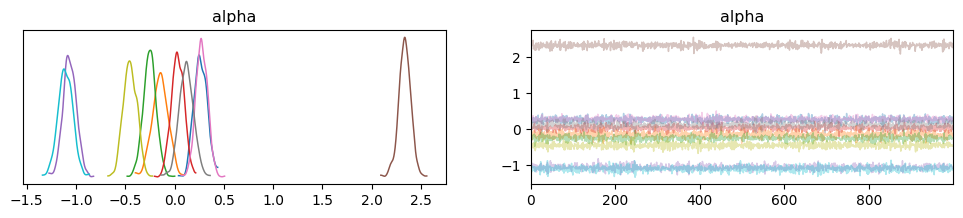

In [6]:
# alpha corresponds to the 'base rate' for each class
# since the dataset is almost balanced, you might think they should be close to 0 for all alphas,
# since all classes are equally likely.
# this is not true. the reason for why is that covariates (the pixels) are not mean 0.
# because of this, each class get an offset that has to do with the average pixel values of thta class
# to improve interpretability, consider standardizing data before training.
az.plot_trace(idata,var_names='alpha');

# if the posteriors (the left panel) looks 'bumpy' you might want more monte carlo samples (i.e. increase N_DRAWS)
# if the samples are correlated (the right panel) you might want to draw several chains, increase the target acceptance rate
# or do something else. check online for advice!

array([[<Axes: title={'center': 'beta'}>,
        <Axes: title={'center': 'beta'}>]], dtype=object)

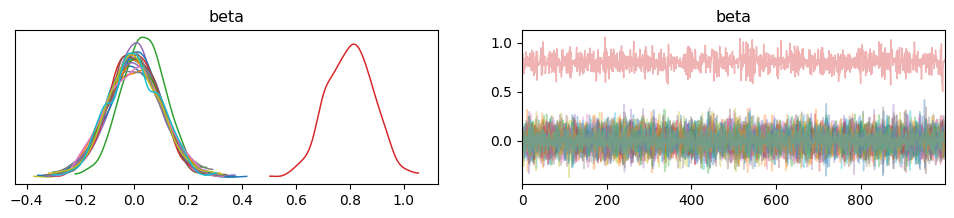

In [7]:
# beta is the weight matrix. it is N_PIXELS long and N_CLASSES wide, so 7840 variables.
# we show a subsample of the variables only.
# we see (as expected) that most coefficients have posterior same as prior (because they are missing for all samples)
# we see (also expected) that two coefficients are nonzero.

# there is a lot of uncertanity about those variables. increasing amount of data (N_TRAIN_SAMPLES) should
# reduce the posterior uncertanity about those coefficients though. not completely. but a bit.
# By the Bernstein-von Mises theorem, we should get normal posteriors asympotically
# https://en.wikipedia.org/wiki/Bernstein%E2%80%93von_Mises_theorem
# so increasing from 5k train samples (what I did last run) to 60k train samples should
# shrink the width of the posterior distrubution to a factor 1/sqrt(60/5) \approx 28%
# paying at least 10 times the compute for 10 times the samples will at best five a reduction in variance
# by two thirds.

az.plot_trace(
  idata,
  var_names="beta",
  coords={
    "beta_dim_0": [0, 10, 20, 30, 40, 50, 60, 70, 80, 90], # show only these pixels
    "beta_dim_1": [0,1] # for these classes
  }
)

### Model Evaluation Setup

This cell prepares the degradation levels for testing and initializes a list to store accuracy results. The evaluation will iterate through different degradation levels of the test data.

In [8]:
# Degradation levels to test (0%, 15%, 30%, ..., 100%)
degradation_levels_pct = [0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100]
degradation_levels = np.array(degradation_levels_pct) / 100.0
accuracy_results = []
nlls = []

print(f"Evaluating model performance across {len(degradation_levels)} degradation levels...")

Evaluating model performance across 21 degradation levels...


In [ ]:
def save_predictions(means,stds,fname):
  n_samples, n_classes = means.shape
  sample_id = np.repeat(np.arange(n_samples), n_classes) # assuming sample ids are just consecutive
  class_id = np.tile(np.arange(n_classes), n_samples)

  # Flatten p_means and p_std (row-major order ensures correct class/sample matching)
  p_mean_flat = means.flatten()
  p_std_flat = stds.flatten()

  # Create the DataFrame
  results_df = pl.DataFrame({
      'sample_id': sample_id,
      'class': class_id,
      'p_mean': p_mean_flat,
      'p_std': p_std_flat
  })

  # Save the DataFrame to CSV
  # Consider using an efficient format, like parquet, instead
  results_df.write_csv(fname)
  print(f"     Results saved to {fname}")

In [ ]:
# ADDED BY IOANNA
# Save the model so there is no need to run it everytime
# use it directly for predictions
import os

MODEL_FILE = 'bayesian_logistic_regression_idata_0.85_blackjax_5000.nc'
idata = az.from_netcdf(MODEL_FILE)

print("Loaded posterior:", idata)
print("Model exists:", os.path.exists(MODEL_FILE))


Loaded posterior: Inference data with groups:
	> posterior
	> sample_stats
	> observed_data
	> constant_data
Model exists: True


In [ ]:
# ADDED BY IOANNA
# Extract posterior weights
# expected shape (chains, draws, pixels, classes)
beta = idata.posterior["beta"].values   
# expected shape (chains, draws, classes)
alpha = idata.posterior["alpha"].values 

# Flatten chains & draws together so shape becomes (draws, pixels, classes)
beta_sd = beta.reshape(-1, beta.shape[-2], beta.shape[-1])
alpha_sd = alpha.reshape(-1, alpha.shape[-1])

print("Posterior shape:", beta_sd.shape, alpha_sd.shape)


Posterior shape: (1000, 784, 10) (1000, 10)


In [ ]:
# ADDED BY IOANNA
# Reduce draws to make prediction fast
rng = np.random.default_rng(42)
idx = rng.choice(beta_sd.shape[0], size=200, replace=False)

beta_sub = beta_sd[idx]
alpha_sub = alpha_sd[idx]


In [ ]:
# Get mean and standard dev per posterior draws
def bayes_preds_for_level(X_deg, beta_draws, alpha_draws):
    # logits[d, s, c] = X[s] x beta[d] + alpha[d]
    logits = np.einsum("sp,dpc->dsc", X_deg, beta_draws) + alpha_draws[:, None, :]
    # softmax
    exps = np.exp(logits - logits.max(axis=2, keepdims=True))
    # expeceted shape (draws, samples, classes)
    probs = exps / exps.sum(axis=2, keepdims=True)   

    return probs.mean(axis=0), probs.std(axis=0)


In [ ]:
# ADDED BY IOANNA
degradation_levels = np.round(np.arange(0.0, 1.01, 0.05), 2)
bayesian_results = {}

for level in degradation_levels:
    print(f"\nDegradation {int(level*100)}%")

    X_test_deg = degrade_images(X_test_flat, level)

    # Faster prediction
    p_means, p_stds = bayes_preds_for_level(X_test_deg, beta_sub, alpha_sub)

    bayesian_results[level] = (p_means, p_stds)



Degradation 0%

Degradation 5%

Degradation 10%

Degradation 15%

Degradation 20%

Degradation 25%

Degradation 30%

Degradation 35%

Degradation 40%

Degradation 45%

Degradation 50%

Degradation 55%

Degradation 60%

Degradation 65%

Degradation 70%

Degradation 75%

Degradation 80%

Degradation 85%

Degradation 90%

Degradation 95%

Degradation 100%


In [ ]:
# ADDED BY IOANNA 
# Saved seperately the mean and std dev per class in case i need the extra data 
# later instead of taking just the mean
def save_predictions(level, means, stds, labels, prefix="blr"):
    n_samples, n_classes = means.shape

    df = pd.DataFrame({
        "id": np.arange(n_samples),
        "true_label": labels[:n_samples]})

    for c in range(n_classes):
        df[f"{prefix}_class_{c}"] = means[:, c]
        df[f"{prefix}_std_{c}"]   = stds[:, c]

    fname = f"{prefix}_predictions_deg_{int(level*100)}.csv"
    df.to_csv(fname, index=False)
    print(f"Saved {fname}, Shape size {df.shape}")

# Save all files
for level, (means, stds) in bayesian_results.items():
    save_predictions(level, means, stds, Y_test, prefix="blr")



Saved blr_predictions_deg_0.csv, Shape size (24000, 22)
Saved blr_predictions_deg_5.csv, Shape size (24000, 22)
Saved blr_predictions_deg_10.csv, Shape size (24000, 22)
Saved blr_predictions_deg_15.csv, Shape size (24000, 22)
Saved blr_predictions_deg_20.csv, Shape size (24000, 22)
Saved blr_predictions_deg_25.csv, Shape size (24000, 22)
Saved blr_predictions_deg_30.csv, Shape size (24000, 22)
Saved blr_predictions_deg_35.csv, Shape size (24000, 22)
Saved blr_predictions_deg_40.csv, Shape size (24000, 22)
Saved blr_predictions_deg_45.csv, Shape size (24000, 22)
Saved blr_predictions_deg_50.csv, Shape size (24000, 22)
Saved blr_predictions_deg_55.csv, Shape size (24000, 22)
Saved blr_predictions_deg_60.csv, Shape size (24000, 22)
Saved blr_predictions_deg_65.csv, Shape size (24000, 22)
Saved blr_predictions_deg_70.csv, Shape size (24000, 22)
Saved blr_predictions_deg_75.csv, Shape size (24000, 22)
Saved blr_predictions_deg_80.csv, Shape size (24000, 22)
Saved blr_predictions_deg_85.csv,

In [ ]:
# ADDED BY IOANNA - can be ignored 
# predictions on train set 
# extract weights
# (chains, draws, 784, 10)
beta = idata.posterior["beta"].values  
# (chains, draws, 10)  
alpha = idata.posterior["alpha"].values    

# Flatten chains and draws
beta = beta.reshape(-1, beta.shape[-2], beta.shape[-1])      
alpha = alpha.reshape(-1, alpha.shape[-1])                    

print(beta.shape) 
print(alpha.shape) 

# Reduce number of samples 
# Downsample posterior draws to reduce compute as it was taking too long and kept crashing 
beta = beta[::50]    
alpha = alpha[::50]

def predict_posterior(X, beta, alpha):
    # Expand dimensions for broadcasting
    X_exp = X[:, None, :]           
    beta_exp = beta[None, :, :, :]   
    
    # Compute logits (sum over pixel dimension)
    logits = (X_exp[..., None] * beta_exp).sum(axis=2) + alpha  

    # Softmax 
    probs = np.exp(logits) / np.exp(logits).sum(axis=2, keepdims=True)

    return probs.mean(axis=1), probs.std(axis=1)

# keep the results 
bayesian_results = {}
degradation_levels = np.round(np.arange(0.0, 1.01, 0.05), 2)
for level in degradation_levels:
    X_test_deg = degrade_images(X_test_flat, level)

    mean_probs, std_probs = predict_posterior(X_test_deg, beta, alpha)

    bayesian_results[level] = (mean_probs, std_probs)
    print(f"Computed level {level}")



(1000, 784, 10)
(1000, 10)


In [ ]:
# for debugging
idata.posterior
print(idata.posterior["beta"].dims)
print(idata.posterior["beta"].shape)


('chain', 'draw', 'beta_dim_0', 'beta_dim_1')
(1, 1000, 784, 10)


In [ ]:
# ADDED BY IOANNA - can be ignored 
# Flatten chains and draws
beta = idata.posterior["beta"].values.squeeze() 
alpha = idata.posterior["alpha"].values.squeeze() 

# Reduce number of posterior samples 
beta = beta[:20]      
alpha = alpha[:20]   

print("beta:", beta.shape)
print("alpha:", alpha.shape)

def predict_posterior_batched(X, beta, alpha, batch_size=2000):
    X = X.reshape(X.shape[0], -1)
    beta_T = beta.transpose(1, 0, 2) 
    alpha_T = alpha.reshape(1, beta.shape[0], beta.shape[2]) 

    # Debug 
    print("beta_T:", beta_T.shape)
    print("alpha_T:", alpha_T.shape)
    means_list, stds_list = [], []
    for i in range(0, len(X), batch_size):
        Xb = X[i:i+batch_size]    
        # Expand X batch for broadcasting
        Xb_exp = Xb[:, :, None]   
        # Multiply pixel by pixel
        weighted = Xb_exp[..., None] * beta_T  

        # Sum over pixels
        logits = weighted.sum(axis=1) + alpha_T
        probs = np.exp(logits) / np.exp(logits).sum(axis=2, keepdims=True)

        means_list.append(probs.mean(axis=1))
        stds_list.append(probs.std(axis=1))

    return np.vstack(means_list), np.vstack(stds_list)

# predict using batches to make it faster 
def batched_predict(X, beta, alpha, batch_size=2000):
    means, stds = [], []
    for start in range(0, len(X), batch_size):
        end = start + batch_size
        m, s = predict_posterior(X[start:end], beta, alpha)
        means.append(m)
        stds.append(s)
    return np.vstack(means), np.vstack(stds)

degradation_levels = np.round(np.arange(0, 1.01, 0.05), 2)
pred_levels = {}
for level in np.round(np.arange(0, 1.01, 0.05), 2):
    print(f"\nComputing level {level}...")
    X_test_deg = degrade_images(X_test_flat, level)

    mean_probs, std_probs = predict_posterior_batched(X_test_deg, beta, alpha, batch_size=2000)
    pred_levels[level] = (mean_probs, std_probs)



beta: (20, 784, 10)
alpha: (20, 10)

Computing level 0.0...
beta_T: (784, 20, 10)
alpha_T: (1, 20, 10)

Computing level 0.05...
beta_T: (784, 20, 10)
alpha_T: (1, 20, 10)

Computing level 0.1...
beta_T: (784, 20, 10)
alpha_T: (1, 20, 10)

Computing level 0.15...
beta_T: (784, 20, 10)
alpha_T: (1, 20, 10)

Computing level 0.2...
beta_T: (784, 20, 10)
alpha_T: (1, 20, 10)

Computing level 0.25...
beta_T: (784, 20, 10)
alpha_T: (1, 20, 10)

Computing level 0.3...
beta_T: (784, 20, 10)
alpha_T: (1, 20, 10)

Computing level 0.35...
beta_T: (784, 20, 10)
alpha_T: (1, 20, 10)

Computing level 0.4...
beta_T: (784, 20, 10)
alpha_T: (1, 20, 10)

Computing level 0.45...
beta_T: (784, 20, 10)
alpha_T: (1, 20, 10)

Computing level 0.5...
beta_T: (784, 20, 10)
alpha_T: (1, 20, 10)

Computing level 0.55...
beta_T: (784, 20, 10)
alpha_T: (1, 20, 10)

Computing level 0.6...
beta_T: (784, 20, 10)
alpha_T: (1, 20, 10)

Computing level 0.65...
beta_T: (784, 20, 10)
alpha_T: (1, 20, 10)

Computing level 0.

In [ ]:
# debugging
print("X shape:", X_test_deg.shape)
print("beta:", beta.shape)
print("alpha:", alpha.shape)


X shape: (24000, 784)
beta: (20, 784, 10)
alpha: (20, 10)


In [ ]:
# For train predictions 
import pandas as pd
import numpy as np

def save_predictions_wide(level, mean_probs, std_probs, labels, prefix="blr"):
    n_samples, n_classes = mean_probs.shape

    # dataframe
    df = pd.DataFrame({
        "id": np.arange(n_samples),
        "true_label": labels[:n_samples]})

    # add columns for each class
    for c in range(n_classes):
        df[f"{prefix}_class_{c}"] = mean_probs[:, c]
        df[f"{prefix}_std_{c}"] = std_probs[:, c]

    fname = f"{prefix}_predictions_deg{int(level*100)}.csv"
    df.to_csv(fname, index=False)
    print(f"Saved {fname} with shape={df.shape}")

train_pred_levels = {}

for level in np.round(np.arange(0, 1.01, 0.05), 2):
    print(f"Computing TRAIN level {level}...")
    X_train_deg = degrade_images(X_train_flat, level)

    mean_probs, std_probs = predict_posterior_batched(X_train_deg, beta, alpha, batch_size=2000)
    train_pred_levels[level] = (mean_probs, std_probs)
for level, (means, stds) in train_pred_levels.items():
    save_predictions_wide(level, means, stds, Y_train, prefix="blr_train")


Computing TRAIN level 0.0...
beta_T: (784, 20, 10)
alpha_T: (1, 20, 10)
Computing TRAIN level 0.05...
beta_T: (784, 20, 10)
alpha_T: (1, 20, 10)
Computing TRAIN level 0.1...
beta_T: (784, 20, 10)
alpha_T: (1, 20, 10)
Computing TRAIN level 0.15...
beta_T: (784, 20, 10)
alpha_T: (1, 20, 10)
Computing TRAIN level 0.2...
beta_T: (784, 20, 10)
alpha_T: (1, 20, 10)
Computing TRAIN level 0.25...
beta_T: (784, 20, 10)
alpha_T: (1, 20, 10)
Computing TRAIN level 0.3...
beta_T: (784, 20, 10)
alpha_T: (1, 20, 10)
Computing TRAIN level 0.35...
beta_T: (784, 20, 10)
alpha_T: (1, 20, 10)
Computing TRAIN level 0.4...
beta_T: (784, 20, 10)
alpha_T: (1, 20, 10)
Computing TRAIN level 0.45...
beta_T: (784, 20, 10)
alpha_T: (1, 20, 10)
Computing TRAIN level 0.5...
beta_T: (784, 20, 10)
alpha_T: (1, 20, 10)
Computing TRAIN level 0.55...
beta_T: (784, 20, 10)
alpha_T: (1, 20, 10)
Computing TRAIN level 0.6...
beta_T: (784, 20, 10)
alpha_T: (1, 20, 10)
Computing TRAIN level 0.65...
beta_T: (784, 20, 10)
alpha_

In [ ]:
# ADDED BY IOANNA 
# Set degradation levels to be evry 5% 
degradation_levels = np.round(np.arange(0.0, 1.01, 0.05), 2)  
# save the results in this dictionary 
bayesian_results = {}
# for every degradation level in the test set perform a posterior predictive sampling 
# using the function created above
for level in degradation_levels:  
    X_test_deg = degrade_images(X_test_flat, level)

    with model:
        p_post = pm.sample_posterior_predictive(
        idata,
        var_names=["p"], 
        predictions={"X_shared": X_test_deg},
        return_inferencedata=False)

    # compute the mean and standard deviations across the posterior samples 
    # p_post["p"] has a shape of (number of draws, number of samples, number of classes)
    p_means = p_post["p"].mean(axis=0)
    p_stds  = p_post["p"].std(axis=0)

    # save the results 
    bayesian_results[level] = (p_means, p_stds)


Sampling: []


Output()

In [ ]:
print(p_post.keys())


In [ ]:
# ADDED BY IOANNA - currently not in use / can be ignored 
# the means and std have the following shape (posterior samples, test samples, classes)
def save_predictions_per_level_long(level, means, stds, labels, prefix="blr"):
    # avg over posterior samples so the shape becomes (number of samples, number of classes)
    means = means.mean(axis=0) 
    stds  = stds.std(axis=0)
    n_samples, n_classes = means.shape

    # Create dataframe - 10 rows per sample
    df = pl.DataFrame({
        "sample_id": np.repeat(np.arange(n_samples), n_classes),
        "true_label": np.repeat(labels[:n_samples], n_classes),
        "class": np.tile(np.arange(n_classes), n_samples),
        "p_mean": means.flatten(),
        "p_std": stds.flatten()})
    # Save the precistions using csv files 
    fname = f"{prefix}_predictions_deg_{int(level*100)}.csv"
    df.write_csv(fname)
    print(f"Saved {fname}, Shape size {df.shape}")
# run for every degradation level 
for level, (means, stds) in bayesian_results.items():
    save_predictions_per_level_long(level, means, stds, Y_test, prefix="blr")


Saved blr_bayes_predictions_deg_0.csv, Shape size (50000, 5)
Saved blr_bayes_predictions_deg_10.csv, Shape size (50000, 5)
Saved blr_bayes_predictions_deg_20.csv, Shape size (50000, 5)
Saved blr_bayes_predictions_deg_30.csv, Shape size (50000, 5)
Saved blr_bayes_predictions_deg_40.csv, Shape size (50000, 5)
Saved blr_bayes_predictions_deg_50.csv, Shape size (50000, 5)
Saved blr_bayes_predictions_deg_60.csv, Shape size (50000, 5)
Saved blr_bayes_predictions_deg_70.csv, Shape size (50000, 5)
Saved blr_bayes_predictions_deg_80.csv, Shape size (50000, 5)
Saved blr_bayes_predictions_deg_90.csv, Shape size (50000, 5)
Saved blr_bayes_predictions_deg_100.csv, Shape size (50000, 5)
time: 18 s (started: 2025-11-20 12:43:51 +01:00)


### Evaluation Loop Execution

This loop applies various degradation levels to the test dataset, performs posterior predictive sampling, and calculates the classification accuracy for each level. The `predictive_model` is defined within the loop to allow `pm.set_data` to update the input variables for each degradation level.

In [10]:
for deg_level in degradation_levels:
    print(f"-> Testing at {deg_level:.0%}% degradation...")
    X_test_degraded = degrade_images(X_test_flat, deg_level)

    # Temporarily set the new degraded data into the PyMC model
    with model:
        # Set the data for prediction
        pm.set_data({'X_shared': X_test_degraded, 'Y_observed': Y_test})

        # Sample from the posterior predictive distribution
        post_pred = pm.sample_posterior_predictive(idata, predictions=True,var_names=['p'])

    p_samples = az.extract(
        post_pred, # from the post_pred object...
        group='predictions', # only the 'prediction' step. not the training step or prior
        var_names='p', # extract these variables defined in the model, ignore the others
        combined=True, # concatenate chains, if there are multiple ones
    ).values
    #print(p_samples.shape) # (N_TEST_SAMLPES,N_CLASSES,N_CHAINS*N_DRAWS)

    p_means = p_samples.mean(axis=-1) # what is the average predicted prob?
    p_std = p_samples.std(axis=-1)    # what is the uncertanity in the predicted prob?
    save_predictions(p_means,p_std,f"test_{int(deg_level*100):03d}.csv")

    y_pred = np.argmax(p_means, axis=1)
    accuracy = np.mean(y_pred == Y_test)
    accuracy_results.append(accuracy)

    prob_of_observations = p_means[np.arange(len(Y_test)), Y_test]
    nll = -np.log(prob_of_observations).mean()
    nlls.append(nll)

    print(f"     Accuracy: {accuracy:.2%}. NLL: {nll:.3f}")

-> Testing at 0%% degradation...


Output()

Output()

     Results saved to test_000.csv
     Accuracy: 73.62%. NLL: 1.023
-> Testing at 15%% degradation...


Output()

     Results saved to test_015.csv
     Accuracy: 73.48%. NLL: 1.006
-> Testing at 30%% degradation...


Output()

     Results saved to test_030.csv
     Accuracy: 73.56%. NLL: 0.987
-> Testing at 45%% degradation...


Output()

     Results saved to test_045.csv
     Accuracy: 73.56%. NLL: 0.969
-> Testing at 60%% degradation...


Output()

     Results saved to test_060.csv
     Accuracy: 73.58%. NLL: 0.950
-> Testing at 75%% degradation...


Output()

     Results saved to test_075.csv
     Accuracy: 73.46%. NLL: 0.925
-> Testing at 85%% degradation...


Output()

     Results saved to test_085.csv
     Accuracy: 73.54%. NLL: 0.909
-> Testing at 90%% degradation...


Output()

     Results saved to test_090.csv
     Accuracy: 71.20%. NLL: 1.160
-> Testing at 95%% degradation...


Output()

     Results saved to test_095.csv
     Accuracy: 53.20%. NLL: 1.654
-> Testing at 100%% degradation...


     Results saved to test_100.csv
     Accuracy: 9.70%. NLL: 2.412
time: 47 s (started: 2025-11-20 09:08:37 +00:00)


### Visualize Results

This cell plots the classification accuracy against varying levels of pixel degradation, providing a visual summary of the model's robustness.

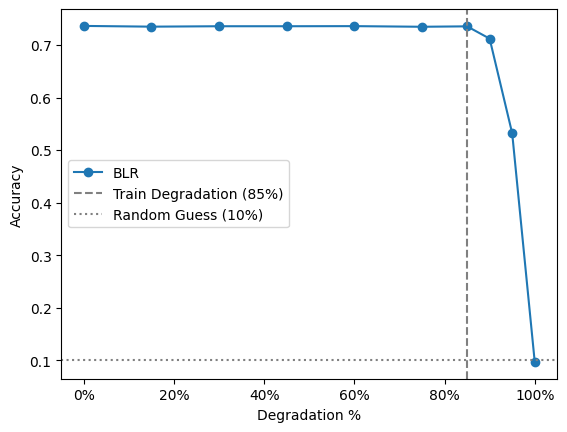

time: 153 ms (started: 2025-11-20 09:09:27 +00:00)


In [11]:
# Look at accuracy.
# Find that the model has uniform performance below the threshold it was trained
# because it don't know what to do with the pixels never seen in training.
fig, ax = plt.subplots()
ax.plot(
    degradation_levels,
    accuracy_results,
    marker='o',
    label='BLR'
)
ax.axvline(DEGRADATION_TRAIN, linestyle='--', label=f'Train Degradation ({DEGRADATION_TRAIN:.0%})',color='grey')
ax.axhline(1/N_CLASSES, linestyle=':', label=f'Random Guess (10%)',color='grey')
ax.set_xlabel('Degradation %')
ax.set_ylabel('Accuracy')
# percent formatter on the ticks
import matplotlib.ticker as mtick
ax.xaxis.set_major_formatter(mtick.PercentFormatter(xmax=1))
ax.legend();



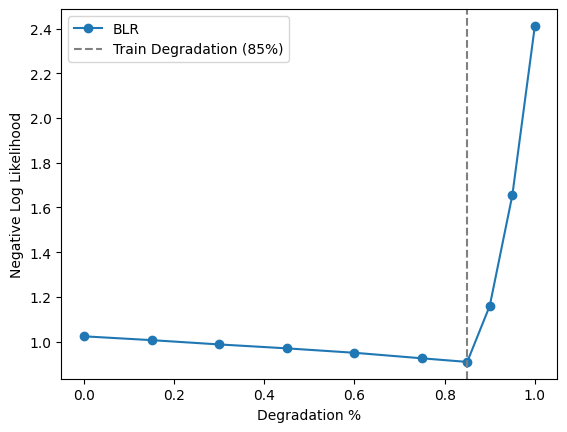

time: 135 ms (started: 2025-11-20 09:09:36 +00:00)


In [12]:
# plot the negative log likeliehood per degradation
# See that the model is best at the degradation it was trained for
fig, ax = plt.subplots()
ax.plot(
    degradation_levels,
    nlls,
    marker='o',
    label='BLR'
)
ax.axvline(DEGRADATION_TRAIN, linestyle='--', label=f'Train Degradation ({DEGRADATION_TRAIN:.0%})',color='grey')
ax.set_xlabel('Degradation %')
ax.set_ylabel('Negative Log Likelihood')
ax.legend()
